<a href="https://colab.research.google.com/github/anuj3509/practice-dl/blob/main/DL_HW3_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import glob
import imageio
import PIL
import time

tf.config.run_functions_eagerly(True)


In [ ]:
# FashionMNIST Dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


4422102/4422102 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

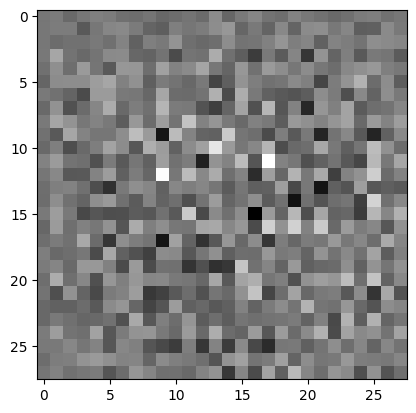

In [ ]:
# Generator Architecture
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Build generator model
generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [ ]:
# Discriminator Architecture
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Build discriminator architecture
discriminator = make_discriminator_model()
discriminator.summary()

decision = discriminator(generated_image)
print(decision)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
# Function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [ ]:
# Generator Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
# Checkpoint save
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training parameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 32

generator_loss_history = []
discriminator_loss_history = []

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Training function
@tf.function
def train_step(images, count):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        if count == 235: # images per batch
            generator_loss_history.append(gen_loss)
            discriminator_loss_history.append(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
# Train and save model
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        count = 0
        for image_batch in dataset:
            count += 1
            train_step(image_batch, count)

        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:checkpoint.save(file_prefix=checkpoint_prefix)

        print('Epoch {} completed in {} sec'.format(epoch + 1, time.time()-start))


In [ ]:
# Function to generate and save synthetic images
def generate_and_save_images(model, epoch, test_input):

    if epoch in {10, 30, 50}:
        print('\nDisplaying images after EPOCH {} '.format(epoch))
        predictions = model(test_input, training=False)
        # training is set as False, so all layers run in inference mode (batchnorm).

        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 8, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()
        print("\n")


Epoch 1 completed in 32.546743392944336 sec
Epoch 2 completed in 40.944469690322876 sec
Epoch 3 completed in 29.92762017250061 sec
Epoch 4 completed in 29.498910665512085 sec
Epoch 5 completed in 30.231664419174194 sec
Epoch 6 completed in 29.333707094192505 sec
Epoch 7 completed in 29.738396406173706 sec
Epoch 8 completed in 29.260231494903564 sec
Epoch 9 completed in 29.748494625091553 sec

Displaying images after EPOCH 10 


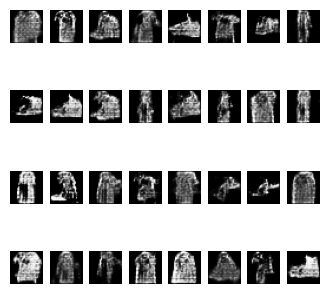



Epoch 10 completed in 30.223461389541626 sec
Epoch 11 completed in 30.191447973251343 sec
Epoch 12 completed in 29.224826097488403 sec
Epoch 13 completed in 29.77360200881958 sec
Epoch 14 completed in 29.30653142929077 sec
Epoch 15 completed in 29.756526470184326 sec
Epoch 16 completed in 29.90117907524109 sec
Epoch 17 completed in 29.82692813873291 sec
Epoch 18 completed in 29.351556301116943 sec
Epoch 19 completed in 30.2413969039917 sec
Epoch 20 completed in 29.597452878952026 sec
Epoch 21 completed in 29.95724606513977 sec
Epoch 22 completed in 29.967801094055176 sec
Epoch 23 completed in 29.8001606464386 sec
Epoch 24 completed in 29.2538480758667 sec
Epoch 25 completed in 29.88079833984375 sec
Epoch 26 completed in 29.42129158973694 sec
Epoch 27 completed in 29.903013944625854 sec
Epoch 28 completed in 29.900816917419434 sec
Epoch 29 completed in 29.893053770065308 sec

Displaying images after EPOCH 30 


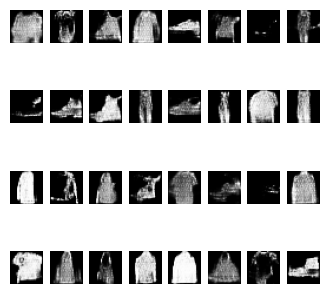



Epoch 30 completed in 30.606163024902344 sec
Epoch 31 completed in 30.453760623931885 sec
Epoch 32 completed in 40.943132638931274 sec
Epoch 33 completed in 30.718672513961792 sec
Epoch 34 completed in 29.518359661102295 sec
Epoch 35 completed in 40.94393491744995 sec
Epoch 36 completed in 29.805047273635864 sec
Epoch 37 completed in 29.963699340820312 sec
Epoch 38 completed in 29.38927149772644 sec
Epoch 39 completed in 29.941240549087524 sec
Epoch 40 completed in 40.94470953941345 sec
Epoch 41 completed in 29.923378944396973 sec
Epoch 42 completed in 29.399693250656128 sec
Epoch 43 completed in 29.587315320968628 sec
Epoch 44 completed in 29.2446608543396 sec
Epoch 45 completed in 30.6083767414093 sec
Epoch 46 completed in 29.919425010681152 sec
Epoch 47 completed in 30.75513792037964 sec
Epoch 48 completed in 40.94348120689392 sec
Epoch 49 completed in 30.913615703582764 sec

Displaying images after EPOCH 50 


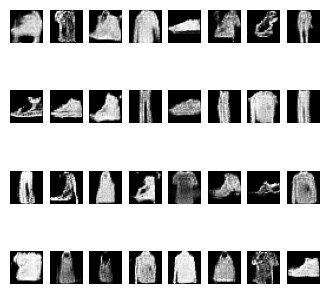



Epoch 50 completed in 31.14641046524048 sec


In [ ]:
# Train DCGAN
train(train_dataset, EPOCHS)

In [ ]:
# Restore Latest Checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

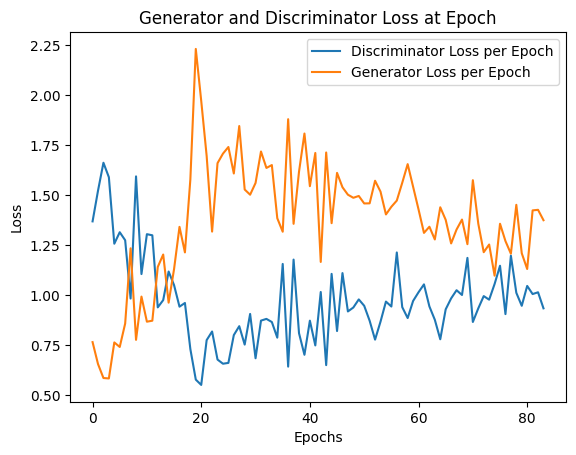

In [ ]:
# Loss curves
plt.plot(discriminator_loss_history, label='Discriminator Loss per Epoch')
plt.plot(generator_loss_history, label='Generator Loss per Epoch')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss at Epoch')
plt.show()
